# Chapter 4 Geocentric models


Jeg læser Statistical Rethinking af Richard McElreath. Titlen er virkelig sigende. Jeg har i sin tid taget bifag i statistik fra Københavns Universitet. Som jeg husker det kom vi ikke i detaljer ind på de forskellige retninger for statistisk inferens.  Undervisningen var primært tilrettelagt med udgangspunkt i likelihoodfunktionen og ikke bayesianske metoder. Statistical Rethinking er om inferens fra en bayesiansk vinkel. Og det kræver virkelig en helt ny måde at tænke på. Se mere her <a target="_blank" href="https://colab.research.google.com/github/carsten-j/Rethinking/blob/main/chapter4.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> og ræk endelig ud, hvis du spotter fejl eller noget som kan forbedres.

This notebook implements most parts of section 4.3 and 4.4 from Statistical Rethinking, 2nd ed. by Richard McElreath. The example code in the book is written in R. Here I try to create similar functionality using Python.

The notebook is not meant to be self-contained. I try to give references to the code samples in the book, but you really need to have the book to follow along.

Please note that the `QuadraticApproximation` class occasiaonlly fails due to the (random) matrix $H$ not being symmetric positive semidefinite. If it happens just try re-running the cell.

## 4.3. Gaussian model of height

In [1]:
import sys

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import utils
import scipy.stats as st
import seaborn as sns
import xarray as xr
from numpy.linalg import inv
from scipy.stats import norm, uniform
import preliz as pz

In [3]:
%load_ext watermark

In [4]:
%watermark -a "Carsten Jørgensen" -u -d -v -m

Author: Carsten Jørgensen

Last updated: 2025-02-09

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.32.0

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit



In [5]:
RANDOM_SEED = 3137
rng = np.random.default_rng(RANDOM_SEED)

In [6]:
# az.style.use("arviz-white")
xr.set_options(display_expand_data=False, display_expand_attrs=False);

![asdf](https://images.routledge.com/common/jackets/crclarge/978020230/9780202306490.jpg)

The dataset originates from a lassic study of the population of the Bushmen of the Kalahari Deselt of Botswana done by Nancy Howell. Read more in the [book](https://www.routledge.com/Demography-of-the-Dobe-Kung/Howell/p/book/9780202306490) also by Nancy Howell.

Number of rows: 544

Variables:

 * height in cm (float)
 * weight in kg (float)
 * age in years (int)
 * male indicator (int)

In [7]:
d = pd.read_csv(
    "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv",
    sep=";",
)

In [8]:
d.head(5)

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [9]:
d.describe(percentiles=[0.055, 0.945])

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
5.5%,81.108550,9.360721,1.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
94.5%,165.735000,54.502894,66.135000,1.000000
max,179.070000,62.992589,88.000000,1.000000


In [10]:
d2 = d[d.age >= 18]

In [11]:
d2.describe(percentiles=[0.055, 0.945])

,height,weight,age,male
count,352.000000,352.000000,352.000000,352.000000
mean,154.597093,44.990486,41.138494,0.468750
std,7.742332,6.456708,15.967855,0.499733
min,136.525000,31.071052,18.000000,0.000000
5.5%,142.875000,35.137504,20.000000,0.000000
50%,154.305000,44.792210,39.000000,0.000000
94.5%,167.005000,55.765876,70.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


In [12]:
def prior_samples(mean, std, uniform_upper, size):
    sample_mu = norm.rvs(loc=mean, scale=std, size=size)
    sample_sigma = uniform.rvs(loc=0, scale=uniform_upper, size=size)
    prior = norm.rvs(loc=sample_mu, scale=sample_sigma)
    return prior

In [13]:
mean = 178.0
sigma = 20.0
uniform_upper = 50.0
n_samples = 1000

In [14]:
prior_20 = prior_samples(mean, sigma, uniform_upper, n_samples)
prior_100 = prior_samples(mean, 100.0, uniform_upper, n_samples)

Figure 4.3. Prior predictive simulation for the height model. Top row
Prior distributions for $\mu$ and $\sigma$. The solid black line for $\mu$ is the 89% HDI
Bottom left: The prior predictive simulation for height, using the priors in
the top row. Values at 3 standard deviations shown on horizontal axis.
Bottom right: Prior predictive simulation using $\mu \sim$ Normal(178, 100)
For $\sigma=100$ we see lots of observations below zero and above 272 (world tallest man).

R code 4.12, 4.13, 4.14

/var/folders/0s/z9xp988n3j78zfjwg3y616x00000gn/T/ipykernel_26325/3589825753.py:49: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


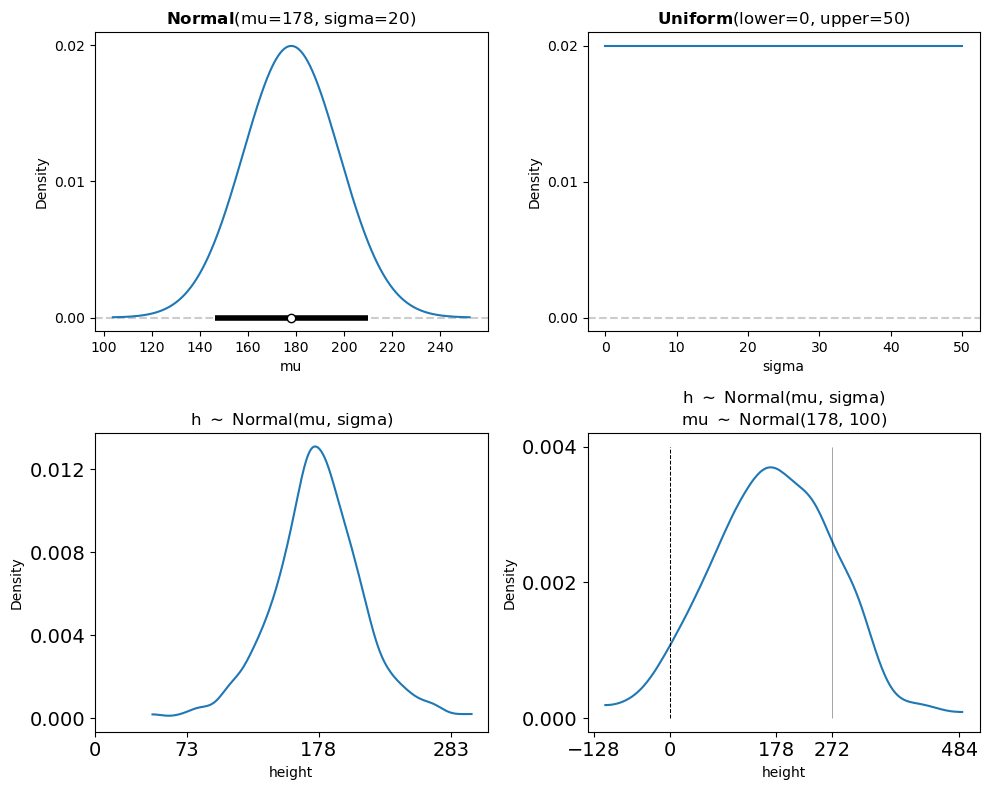

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), layout="constrained")

# top left
pz.Normal(mu=mean, sigma=sigma).plot_pdf(
    pointinterval=True,
    legend="title",
    interval="quantiles",
    levels=[0.055, 0.5, 0.945],
    ax=ax[0, 0],
)
ax[0, 0].set(ylabel="Density", xlabel="mu", yticks=(0, 0.01, 0.02))

# top right
pz.Uniform(lower=0, upper=uniform_upper).plot_pdf(legend="title", ax=ax[0, 1])
ax[0, 1].set(ylabel="Density", xlabel="sigma", yticks=(0, 0.01, 0.02))

# buttom left
az.plot_kde(prior_20, ax=ax[1, 0])
ax[1, 0].set(
    title=r"h $\sim$ Normal(mu, sigma)",
    ylabel="Density",
    xlabel="height",
    yticks=(0, 0.004, 0.008, 0.012),
    xticks=(0, 73, 178, 283),
)

# buttom right
az.plot_kde(prior_100, ax=ax[1, 1])
ax[1, 1].set(
    title=r"h $\sim$ Normal(mu, sigma)" + "\n" + r"mu $\sim$ Normal(178, 100)",
    ylabel="Density",
    xlabel="height",
    xticks=(-128, 0, 178, 272, 484),
    yticks=(0, 0.002, 0.004),
)
ax[1, 1].vlines(
    x=0, ymin=0, ymax=0.004, linestyle="dashed", color="black", linewidth=0.75
)
ax[1, 1].vlines(
    x=272,
    ymin=0,
    ymax=0.004,
    linestyle="solid",
    color="black",
    alpha=0.5,
    linewidth=0.5,
)

fig.tight_layout()

### Prior predictive simulation

Quoting from Statistical Rethinking page 83

> Prior predictive simulation is very useful for assigning sensible priors, because it can be quite hard to anticipate how priors influence the observable variables.

and again from page 84

> The important thing is that your prior not be based on the values in the data, but only on what you know about the data before you see it.

Python has a library called [PreliZ](https://preliz.readthedocs.io/en/latest/index.html) that is a tool-box for prior elicitation. One feature is called “[prior predictive assistant](https://preliz.readthedocs.io/en/latest/examples/observed_space_examples.html#prior-predictive-assistant)” (or PPA for short). Note this a still under development. PPA has several goals one of them being

> We want to select distributions based on prior information and NOT based on the observed data we want to fit.

Please consult the official documention for further information.

In [16]:
def a_preliz_model():
    mu = pz.Normal(mu=178, sigma=20).rvs()
    sigma = pz.Uniform(lower=0, upper=50).rvs()
    y = pz.Normal(mu, sigma).rvs(100)
    return mu, sigma, y

/Users/rehabnaeem/miniforge3/lib/python3.12/site-packages/preliz/predictive/ppa.py:65: UserWarning: "This is an experimental method under development, use with caution.
  warnings.warn(""""This is an experimental method under development, use with caution.""")


RuntimeError: To run ppa, you need use the magic `%matplotlib widget`
['mu', 'sigma', 'y'] {'mu': Normal, 'sigma': Uniform}


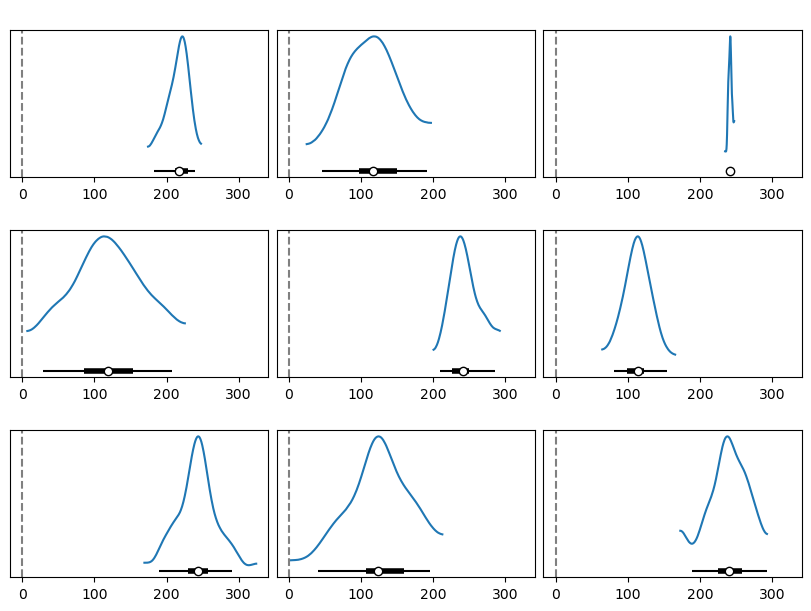

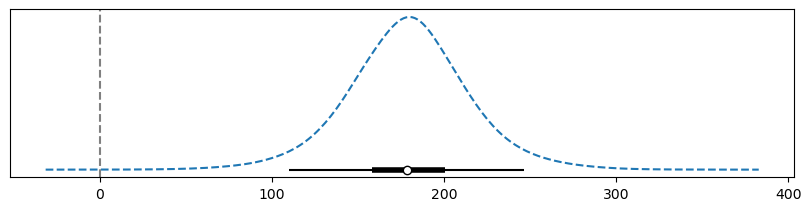

In [17]:
pz.ppa(a_preliz_model)

### 4.3.3 Grid approximation of the posterior distribution.

R code 4.16

In [18]:
mu_list = np.linspace(150, 160, 200)
sigma_list = np.linspace(7, 9, 200)

# Priors
mu_prior = st.norm(178, 20).logpdf(mu_list)
sigma_prior = st.norm(0, 50).logpdf(sigma_list)

# Likelihood
posterior = (
    st.norm(mu_list.reshape(-1, 1, 1), sigma_list.reshape(1, -1, 1))
    .logpdf(d2.height)
    .sum(axis=2)
    # Priors
    + mu_prior
    + sigma_prior
)

# Numerical trick to avoid overfloat. See Statistical Rethinking note 73
posterior = np.exp(posterior - posterior.max())

R code 4.17, 4.18

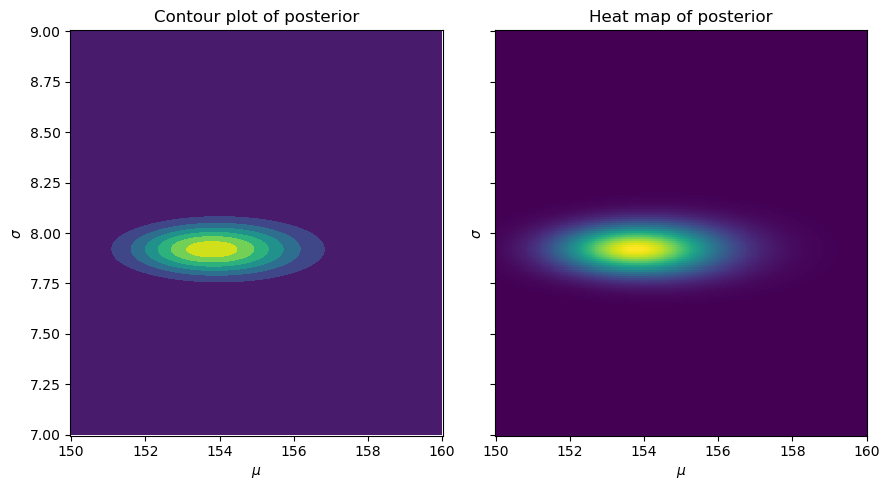

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 5), sharex=True, sharey=True)
X, Y = np.meshgrid(mu_list, sigma_list)

axes[0].contourf(X, Y, posterior)
axes[0].set(xlabel=r"$\mu$", ylabel=r"$\sigma$", title="Contour plot of posterior")

axes[1].pcolormesh(X, Y, posterior)
axes[1].set(xlabel=r"$\mu$", ylabel=r"$\sigma$", title="Heat map of posterior")

fig.tight_layout()

In [20]:
posterior /= posterior.sum()

In [21]:
# Flatten the 2D array
flattened_probabilities = posterior.flatten()
# Sample indices from the flattened array
sampled_indices_flat = np.random.choice(
    flattened_probabilities.size, p=flattened_probabilities, size=10000
)
# Reshape sampled indices back to 2D
sampled_indices_2d = np.unravel_index(sampled_indices_flat, posterior.shape)

In Statistical Rethinking a scatterplot is used to visualize the posterior distribution. Personally I tend
to prefer a hexbin plot. What would be your choice?

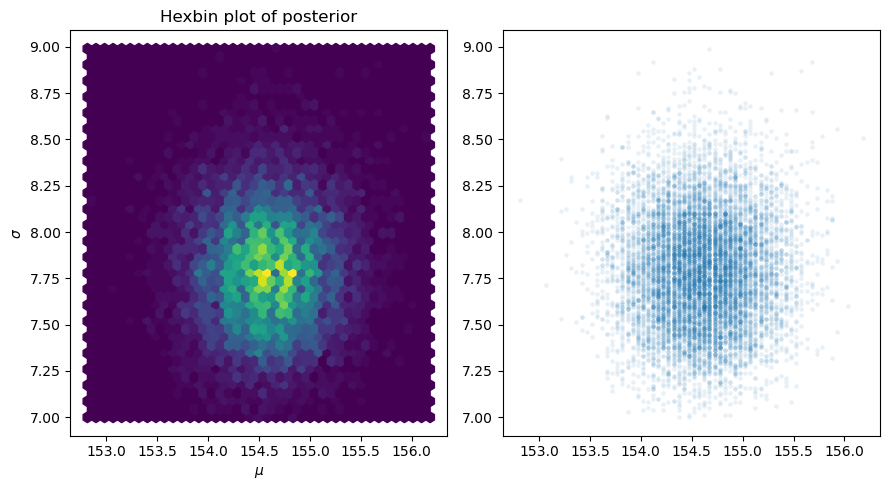

In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 5))
ax[0].hexbin(
    x=mu_list[sampled_indices_2d[0]], y=sigma_list[sampled_indices_2d[1]], gridsize=40
)
ax[0].set(xlabel=r"$\mu$", ylabel=r"$\sigma$", title="Hexbin plot of posterior")
ax[1].scatter(
    x=mu_list[sampled_indices_2d[0]],
    y=sigma_list[sampled_indices_2d[1]],
    alpha=0.1,
    marker=".",
    linewidth=0.1,
)
fig.tight_layout()

Yet another visualization would be to include the marginal distribution in the plot. You can do that with Seaborn.

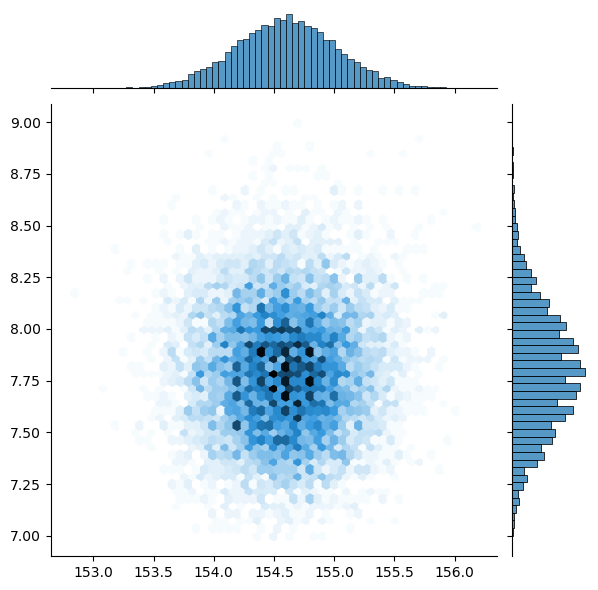

In [23]:
sns.jointplot(
    x=mu_list[sampled_indices_2d[0]], y=sigma_list[sampled_indices_2d[1]], kind="hex"
);

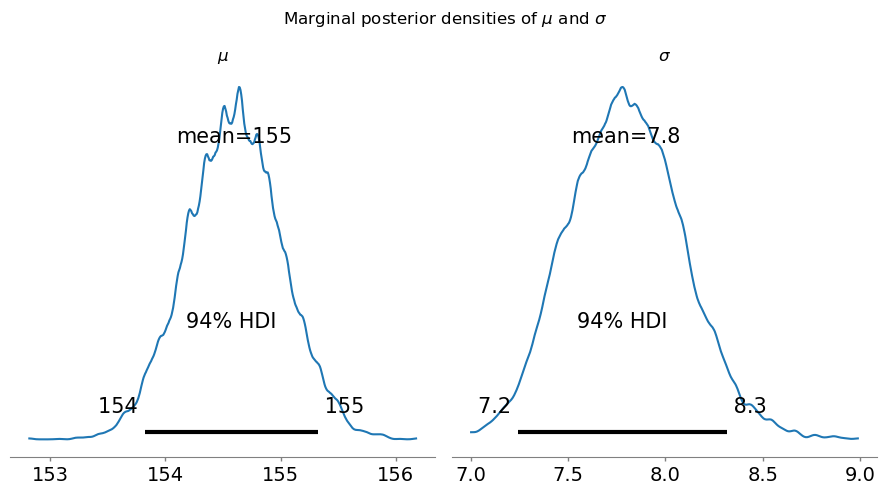

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 5))
az.plot_posterior(mu_list[sampled_indices_2d[0]], ax=ax[0])
ax[0].set(title=r"$\mu$")
az.plot_posterior(sigma_list[sampled_indices_2d[1]], ax=ax[1])
ax[1].set(title=r"$\sigma$")
fig.suptitle(r"Marginal posterior densities of $\mu$ and $\sigma$")
fig.tight_layout()

#### Posterior compatibility intervals:

R code 4.22

In [25]:
print(az.hdi(mu_list[sampled_indices_2d[0]]))
print(az.hdi(sigma_list[sampled_indices_2d[0]]))

[153.81909548 155.32663317]
[7.7638191  8.06532663]


R code 4.23

In [26]:
d3 = d2.sample(n=20)

R code 4.24

In [27]:
mu_list = np.linspace(150, 170, 200)
sigma_list = np.linspace(4, 20, 200)

post2 = (
    # Likelihood
    st.norm(mu_list.reshape(-1, 1, 1), sigma_list.reshape(1, -1, 1))
    .logpdf(d3.height)
    .sum(axis=2)
    # Priors
    + st.norm(178, 20).logpdf(mu_list)
    + st.norm(0, 50).logpdf(sigma_list)
)

# See note  in Statistical Rethinking 2nd ed for an explation of why to subtract post2.max()
post2 = np.exp(post2 - post2.max())
post2 /= post2.sum()

post2_flatten = post2.flatten()
indicies = np.random.choice(post2_flatten.size, p=post2_flatten, size=10000)
sample2_rows = np.unravel_index(indicies, post2.shape)

sample2_mu = mu_list[sample2_rows[0]]
sample2_sigma = sigma_list[sample2_rows[1]]

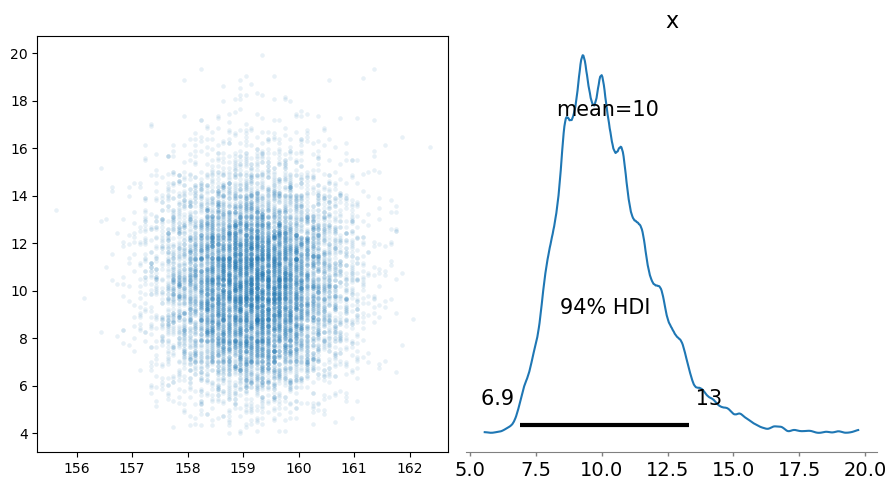

In [28]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 5))

ax[0].scatter(
    x=mu_list[sampled_indices_2d[0]],
    y=sigma_list[sampled_indices_2d[1]],
    alpha=0.1,
    marker=".",
    linewidth=0.1,
)
az.plot_posterior(sample2_sigma, ax=ax[1])
fig.tight_layout()

### 4.3.5. Finding the posterior distribution with quadratic approximation

The follwing function is based on [quap5](https://pypi.org/project/quad5/).

In [29]:
start = {"mu": d2.height.mean(), "sigma": d2.height.std()}

In [30]:
with pm.Model() as model_m4_1:
    mu = pm.Normal("mu", mu=178, sigma=20)
    sigma = pm.Uniform("sigma", 0, 50)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height)
    custom_step_m4_1 = utils.QuadraticApproximation([mu, sigma], model_m4_1)
    m4_1 = pm.sample(draws=1000, chains=1, tune=0, step=custom_step_m4_1)

/Users/rehabnaeem/miniforge3/lib/python3.12/site-packages/pytensor/configparser.py:44: FutureWarning: hessian will stop negating the output in a future version of PyMC.
To suppress this warning set `negate_output=False`
  return f(*args, **kwargs)
Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [mu, sigma]


Output()

Sampling 1 chain for 0 tune and 1_000 draw iterations (0 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [31]:
m4_1

Inference data with groups:
	> posterior
	> observed_data

In [32]:
def precis(samples, var_names=None):
    return az.summary(samples, kind="stats", hdi_prob=0.89, var_names=var_names).round(2)

In [33]:
precis(m4_1)

,mean,sd,hdi_5.5%,hdi_94.5%
mu,154.62,0.4,153.97,155.22
sigma,7.72,0.3,7.22,8.19


In [34]:
with pm.Model() as model_m4_2:
    mu = pm.Normal("mu", mu=178, sigma=0.1)
    sigma = pm.Uniform("sigma", 0, 50)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height)
    custom_step_m4_2 = utils.QuadraticApproximation([mu, sigma], model_m4_2)
    m4_2 = pm.sample(draws=1000, chains=1, tune=0, step=custom_step_m4_2)

/Users/rehabnaeem/miniforge3/lib/python3.12/site-packages/pytensor/configparser.py:44: FutureWarning: hessian will stop negating the output in a future version of PyMC.
To suppress this warning set `negate_output=False`
  return f(*args, **kwargs)
Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [mu, sigma]


Output()

Sampling 1 chain for 0 tune and 1_000 draw iterations (0 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [35]:
precis(m4_2)

,mean,sd,hdi_5.5%,hdi_94.5%
mu,177.87,0.10,177.70,178.01
sigma,24.54,0.98,23.06,26.20


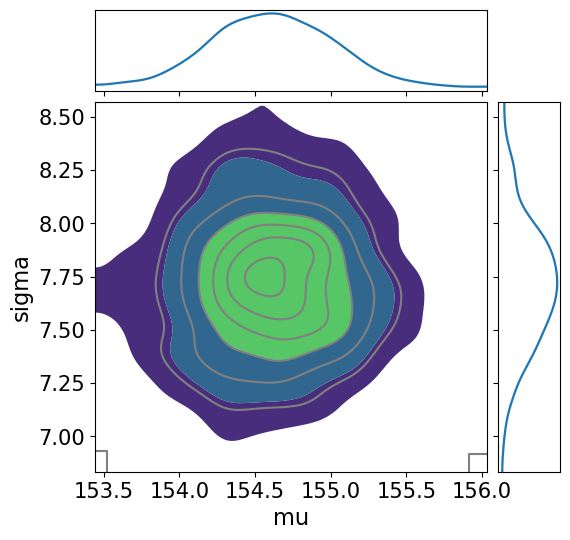

In [36]:
az.plot_pair(m4_1, kind="kde", marginals=True, figsize=(6, 6));

In [37]:
def vcov(custom_step):
    return custom_step.covariance

In [38]:
vcov(custom_step_m4_1)

array([[0.16973961, 0.00021803],
       [0.00021803, 0.08490583]])

In [39]:
def cov2cor(c: np.ndarray) -> np.ndarray:
    """
    Return a correlation matrix given a covariance matrix.
    : c = covariance matrix
    """
    D = np.zeros(c.shape)
    np.fill_diagonal(D, np.sqrt(np.diag(c)))
    invD = inv(D)
    return invD @ c @ invD

In [40]:
cov2cor(vcov(custom_step_m4_1))

array([[1.        , 0.00181618],
       [0.00181618, 1.        ]])

In [41]:
# See https://python.arviz.org/en/stable/getting_started/CreatingInferenceData.html#from-dataframe
def convert_to_inference_data(df):
    df["chain"] = 1
    df["draw"] = np.arange(len(df), dtype=int)
    df = df.set_index(["chain", "draw"])
    xdata = xr.Dataset.from_dataframe(df)
    idata = az.InferenceData(posterior=xdata)
    return idata


# Add the `to_inference_data()` method to the DataFrame class
pd.DataFrame.convert_to_inference_data = convert_to_inference_data

In [42]:
custom_step_m4_1.covariance

array([[0.16973961, 0.00021803],
       [0.00021803, 0.08490583]])

In [43]:
def extract_samples(custom_step, size=10000):
    samples = rng.multivariate_normal(mean=custom_step.mode, cov=custom_step.covariance, size=size)
    df = pd.DataFrame({"mu": samples[:, 0], "sigma": samples[:, 1]})
    return df.convert_to_inference_data()

In [44]:
post = extract_samples(custom_step_m4_1)

In [45]:
precis(post)

,mean,sd,hdi_5.5%,hdi_94.5%
mu,154.60,0.41,153.97,155.28
sigma,7.72,0.29,7.24,8.16


### 4.4.1. The linear model strategy.

In [46]:
N = 100
x = np.linspace(d2.weight.min(), d2.weight.max())
xbar = d2.weight.mean()

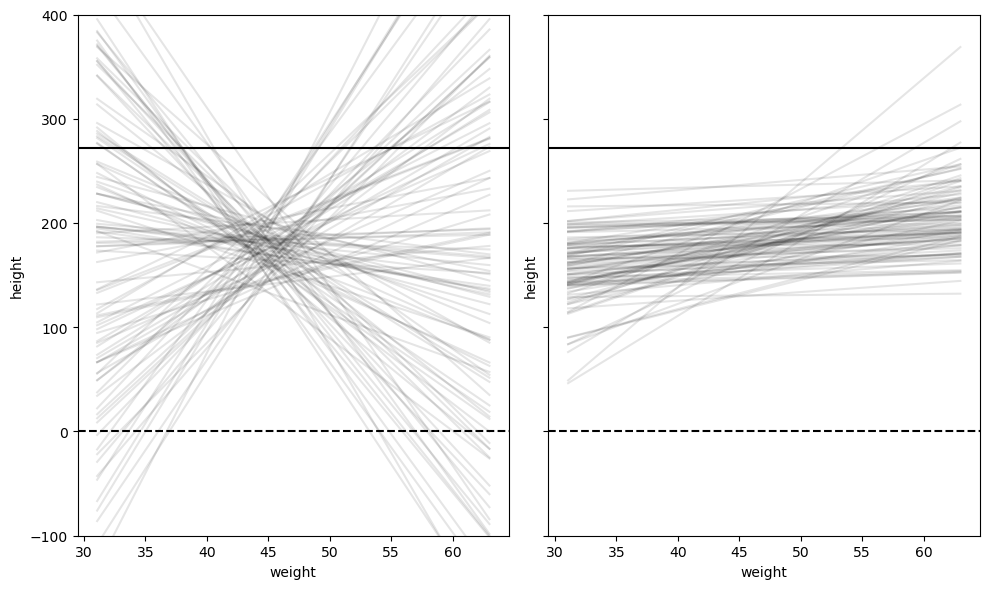

In [47]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 6), sharey=True)

a = st.norm(loc=178, scale=20).rvs(N)
b = st.norm(loc=0, scale=10).rvs(N)
for i in range(N):
    ax[0].plot(x, a[i] + b[i] * (x - xbar), color="black", alpha=0.1)
ax[0].axhline(272, color="black")
ax[0].axhline(0, color="black", linestyle="--")
ax[0].set(xlabel="weight", ylabel="height", ylim=(-100, 400))

# Sample from new prior
a = st.norm(loc=178, scale=20).rvs(N)
b = st.lognorm(scale=np.exp(0), s=1).rvs(N)

# Plot regression lines from the prior
for i in range(N):
    ax[1].plot(x, a[i] + b[i] * (x - xbar), color="black", alpha=0.1)
ax[1].axhline(272, color="black")
ax[1].axhline(0, color="black", linestyle="--")
ax[1].set(xlabel="weight", ylabel="height", ylim=(-100, 400))

fig.tight_layout()

In [48]:
xbar = d2.weight.mean()

In [49]:
with pm.Model() as model_m4_3:

    weight = pm.ConstantData("w", d2.weight, dims="obs_id")

    sigma = pm.Uniform("sigma", 0, 10)
    a = pm.Normal("a", 178, 20)
    b = pm.LogNormal("b", 0, 1)

    mu = pm.Deterministic("mu", a + b * (weight - xbar), dims="obs_id")
    # likelihood
    likelihood = pm.Normal(
        "h", mu=mu, sigma=sigma, observed=d2["height"], dims="obs_id"
    )

    custom_step_m4_3 = utils.QuadraticApproximation([a, b, sigma], model_m4_3)
    m4_3 = pm.sample(draws=1000, chains=1, tune=0, step=custom_step_m4_3)

/Users/rehabnaeem/miniforge3/lib/python3.12/site-packages/pymc/data.py:291: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
/Users/rehabnaeem/miniforge3/lib/python3.12/site-packages/pytensor/configparser.py:44: FutureWarning: hessian will stop negating the output in a future version of PyMC.
To suppress this warning set `negate_output=False`
  return f(*args, **kwargs)
Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, b, sigma]


Output()

Sampling 1 chain for 0 tune and 1_000 draw iterations (0 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [50]:
m4_3

Inference data with groups:
	> posterior
	> observed_data
	> constant_data

In [51]:
precis(m4_3, var_names="~mu")

,mean,sd,hdi_5.5%,hdi_94.5%
sigma,5.07,0.19,4.77,5.37
a,154.60,0.27,154.20,155.04
b,0.90,0.04,0.84,0.97


In [52]:
np.around(custom_step_m4_3.covariance, 3)

array([[ 0.073, -0.   ,  0.   ],
       [-0.   ,  0.002, -0.   ],
       [ 0.   , -0.   ,  0.037]])

In [53]:
posterior_mean = m4_3.mean()

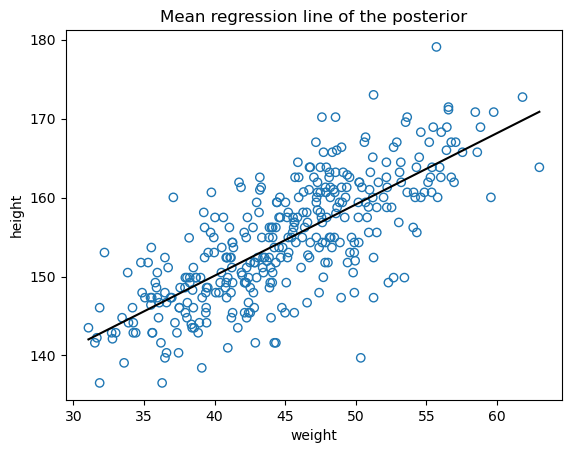

In [54]:
fig, ax = plt.subplots()
a = posterior_mean.posterior["a"].values
b = posterior_mean.posterior["b"].values
x = np.linspace(d2.weight.min(), d2.weight.max(), 10)
y = a + b * (x - xbar)
ax.scatter(d2.weight, d2.height, label="data", facecolor="none", edgecolor="C0")
ax.plot(x, y, label="posterior mean", color="black")
ax.set(xlabel="weight", ylabel="height", title="Mean regression line of the posterior");

In [55]:
weight_numpy = d2["weight"].to_numpy()
height_numpy = d2["height"].to_numpy()

/Users/rehabnaeem/miniforge3/lib/python3.12/site-packages/pytensor/configparser.py:44: FutureWarning: hessian will stop negating the output in a future version of PyMC.
To suppress this warning set `negate_output=False`
  return f(*args, **kwargs)
Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, b, sigma]


Output()

Sampling 1 chain for 0 tune and 1_000 draw iterations (0 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
/Users/rehabnaeem/miniforge3/lib/python3.12/site-packages/pytensor/configparser.py:44: FutureWarning: hessian will stop negating the output in a future version of PyMC.
To suppress this warning set `negate_output=False`
  return f(*args, **kwargs)
Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, b, sigma]


Output()

Sampling 1 chain for 0 tune and 1_000 draw iterations (0 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
/Users/rehabnaeem/miniforge3/lib/python3.12/site-packages/pytensor/configparser.py:44: FutureWarning: hessian will stop negating the output in a future version of PyMC.
To suppress this warning set `negate_output=False`
  return f(*args, **kwargs)
Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, b, sigma]


Output()

Sampling 1 chain for 0 tune and 1_000 draw iterations (0 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
/Users/rehabnaeem/miniforge3/lib/python3.12/site-packages/pytensor/configparser.py:44: FutureWarning: hessian will stop negating the output in a future version of PyMC.
To suppress this warning set `negate_output=False`
  return f(*args, **kwargs)
Sequential sampling (1 chains in 1 job)
QuadraticApproximation: [a, b, sigma]


Output()

Sampling 1 chain for 0 tune and 1_000 draw iterations (0 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


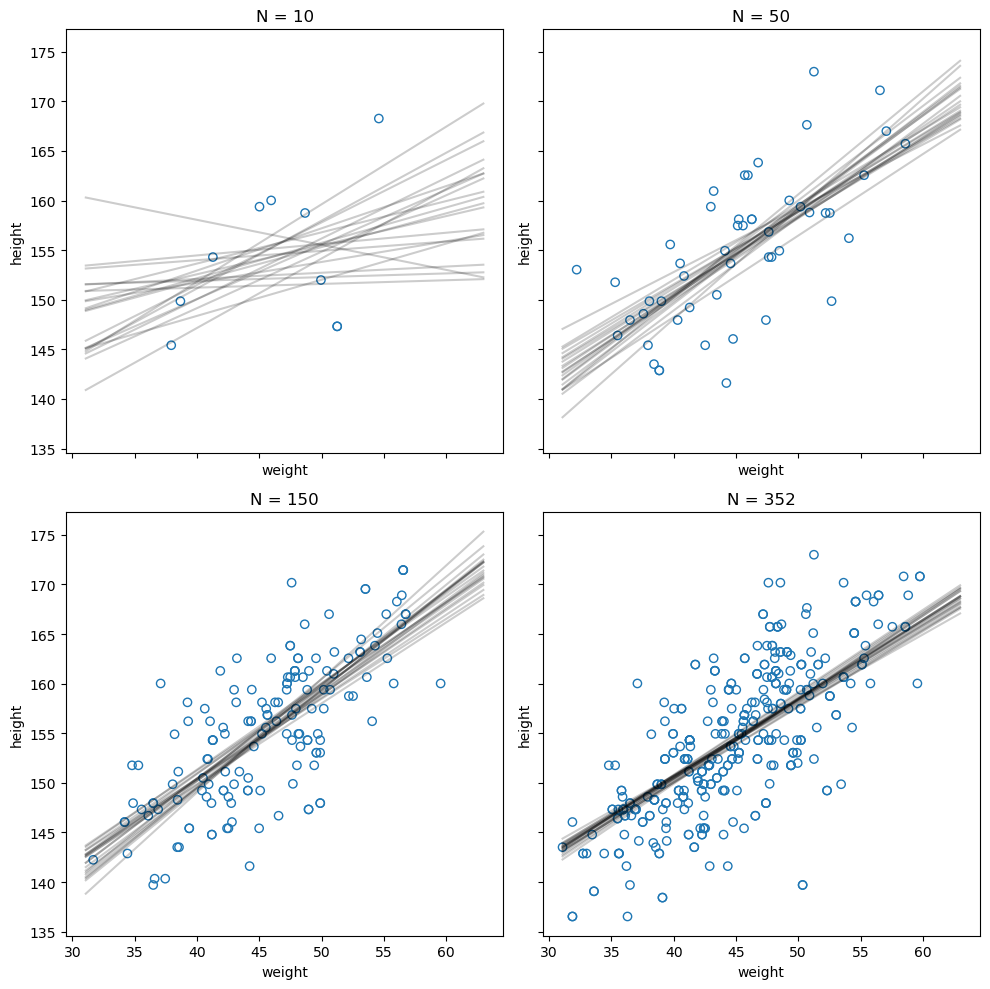

In [56]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharey=True, sharex=True)
for N, ax in zip((10, 50, 150, 352), axes.flatten()):
    idx = np.random.choice(len(weight_numpy), N)
    weight_, height_ = weight_numpy[idx], height_numpy[idx]

    xbar = np.mean(weight_)

    with pm.Model() as m:
        sigma = pm.Uniform("sigma", 0, 10)
        a = pm.Normal("a", 178, 20)
        b = pm.LogNormal("b", 0, 1)
        mu = pm.Deterministic("mu", a + b * (weight_ - xbar))
        # Define likelihood
        likelihood = pm.Normal("w", mu=mu, sigma=sigma, observed=height_)
        custom_step = utils.QuadraticApproximation([a, b, sigma], m)
        idata = pm.sample(draws=1000, chains=1, tune=0, step=custom_step)

    sample_size = 20
    samples = az.extract(idata, num_samples=sample_size, rng=True)

    ax.scatter(weight_, height_, facecolor="none", edgecolor="C0")

    for i in range(sample_size):
        a = samples.get("a")[i].values
        b = samples.get("b")[i].values
        x = np.linspace(weight_numpy.min(), weight_numpy.max(), 10)
        y = a + b * (x - xbar)
        ax.plot(x, y, color="black", alpha=0.2)
    ax.set(xlabel="weight", ylabel="height", title=f"N = {N}")

fig.tight_layout()

In [57]:
xbar = d2.weight.mean()
a = m4_3.get("posterior")["a"].values
b = m4_3.get("posterior")["b"].values
y = a + b * (50 - xbar)

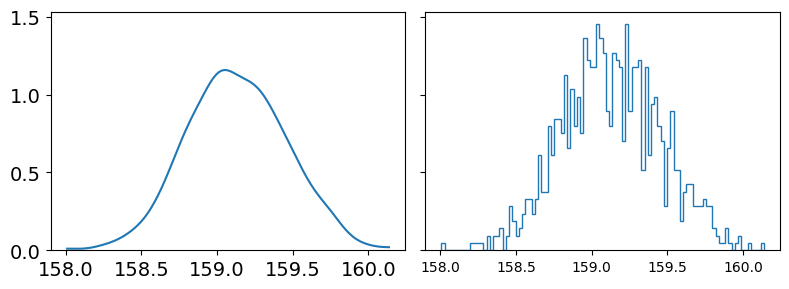

In [58]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 3), sharex=True, sharey=True)
az.plot_kde(y[0], ax=ax[0], backend_kwargs={"title": "foo"})
ax[1].hist(y[0], density=True, bins=100, histtype="step")
fig.tight_layout()

In [62]:
az.hdi(y[0])

array([158.5599949 , 159.76088266])

In [63]:
pm.sample_posterior_predictive(m4_3, model=model_m4_3, extend_inferencedata=True)

Sampling: [h]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> observed_data
	> constant_data

#### Figure 4.10

R code 4.59 - 4.62

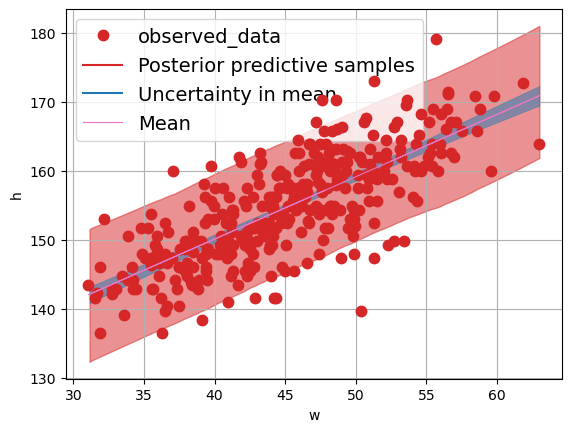

In [64]:
az.plot_lm(
    idata=m4_3,
    x="w",
    y="h",
    y_model="mu",
    kind_pp="hdi",
    kind_model="hdi"
);